# Лабораторная работа №5. Применение сверточных нейронных сетей (бинарная классификация)

Данные: Набор данных DogsVsCats, который состоит из изображений различной размерности, содержащих фотографии собак и кошек. Обучающая выборка включает в себя 25 тыс. изображений (12,5 тыс. кошек: cat.0.jpg, …, cat.12499.jpg и 12,5 тыс. собак: dog.0.jpg, …, dog.12499.jpg), а контрольная выборка содержит 12,5 тыс. неразмеченных изображений. Скачать данные, а также проверить качество классификатора на тестовой выборке можно на сайте Kaggle -> https://www.kaggle.com/c/dogs-vs-cats/data

In [0]:
import tensorflow as tf
import IPython.display as display
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import pathlib
import zipfile
import os

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  print(
      '\n\nThis error most likely means that this notebook is not '
      'configured to use a GPU.  Change this in Notebook Settings via the '
      'command palette (cmd/ctrl-shift-P) or the Edit menu.\n\n')
  raise SystemError('GPU device not found')

In [0]:
DRIVE_DIR = '/content/drive/My Drive/Colab Notebooks/5/'

In [5]:
with zipfile.ZipFile(f'{DRIVE_DIR}train.zip', 'r') as zip_ref:
    zip_ref.extractall('./datasets/')

train_data_dir = pathlib.Path('./datasets/train/')

IMAGE_COUNT = len(list(train_data_dir.glob('*')))
IMAGE_COUNT

25000

Мы должны привести все картинки к одному размеру.
Для этого необходимо найти наибольшие размеры картинок.

In [6]:
MAX_HEIGHT, MAX_WIDTH = (256, 256)
MAX_HEIGHT, MAX_WIDTH

(256, 256)

In [0]:
PATHS = [str(item) for item in train_data_dir.glob('*')]

cats_count = len(list(train_data_dir.glob('cat*')))
LABLES = np.concatenate([['cat'] * cats_count, ['dog'] * (IMAGE_COUNT - cats_count)])#

#### Tensorflow Model wrapper:

In [0]:
import random
import datetime
from keras_preprocessing.image import DataFrameIterator

class Model:
    EPOCH_COUNT = 10
    
    def __init__(self, layers=[], model=None, optimizer=None):
        self.layers = layers
        self.model = model
        self.optimizer = optimizer or tf.keras.optimizers.SGD(
            learning_rate=0.1
        )
        if not self.model:
            self.initialize()
        print('----------------------------------------------------------------------------------------')
        print(self.summary())
        print('----------------------------------------------------------------------------------------')

    def initialize(self):
        self.model = tf.keras.models.Sequential(self.layers)
        self.model.compile(optimizer=self.optimizer, loss='binary_crossentropy', metrics=['accuracy'])
        
    def _train_on_batches(self, iterator, batch_count, epochs=None, **kwargs):
        epochs = epochs or self.EPOCH_COUNT
        loss, tran_accuracy, val_loss, val_accuracy = np.zeros((4, batch_count, epochs))

        for i in range(batch_count):
            print('----------------------------------------------------------------------------------------')
            print(f'Train on batch #{i}')
            print('----------------------------------------------------------------------------------------')
            x, y = next(iterator)
            batch_history = self.model.fit(x,  y, epochs=epochs, **kwargs)
            loss[i, :] = batch_history.history['loss']
            tran_accuracy[i, :] = batch_history.history['accuracy']
            if batch_history.history.get('val_accuracy'):
                val_accuracy[i, :] = batch_history.history.get('val_accuracy')[-1]
                val_loss[i, :] = batch_history.history.get('val_loss')[-1]


        val_loss = val_loss if np.any(val_loss) else None
        val_accuracy = val_accuracy if np.any(val_accuracy) else None

        return loss, tran_accuracy, val_loss, val_accuracy

    def _train_on_full_data(self, iterator, epochs=None, **kwargs):
        print('----------------------------------------------------------------------------------------')
        print(f'Train on full data')
        print('----------------------------------------------------------------------------------------')
        epochs = epochs or self.EPOCH_COUNT
        history = self.model.fit(iterator, epochs=epochs, **kwargs)
        loss = np.array([history.history['loss']])
        tran_accuracy = np.array([history.history['accuracy']])
        val_accuracy = np.array([history.history.get('val_accuracy')])
        val_loss = np.array([history.history.get('val_loss')])

        val_loss = val_loss if np.any(val_loss) else None
        val_accuracy = val_accuracy if np.any(val_accuracy) else None

        return loss, tran_accuracy, val_loss, val_accuracy

    def _plot_train_accuracy_graphs(self, loss, tran_accuracy, validation_loss=[], validation_accuracy=[], mode='batch'):
        print('----------------------------------------------------------------------------------------')
        if mode == 'batch':
            plt.figure(figsize=(15, 12))
            ax_shape = (2, 2)
        else:
            plt.figure(figsize=(15,5))
            ax_shape = (1, 2)

        xlabel = 'Epochs'
        ax = plt.subplot(*ax_shape, 1)
        ax.set_xlabel(xlabel, fontsize=14)
        ax.set_ylabel('Loss', fontsize=14)

        epochs_loss = np.average(loss, axis=0)
        ax.plot(epochs_loss)
        if np.any(validation_loss):
            val_epochs_loss = np.average(validation_loss, axis=0)
            ax.plot(val_epochs_loss, '--')


        ax = plt.subplot(*ax_shape, 2)
        ax.set_xlabel(xlabel, fontsize=14)
        ax.set_ylabel('Accuracy', fontsize=14)

        epochs_accuracy = np.average(tran_accuracy, axis=0)
        ax.plot(epochs_accuracy)
        if np.any(validation_accuracy):
            val_epochs_accuracy = np.average(validation_accuracy, axis=0)
            ax.plot(val_epochs_accuracy, '--')

        if mode == 'batch':
            xlabel = 'Batches'
            ax = plt.subplot(*ax_shape, 3)
            ax.set_xlabel(xlabel, fontsize=14)
            ax.set_ylabel('Loss', fontsize=14)

            batches_loss = np.average(loss, axis=1)
            ax.plot(batches_loss)
            if np.any(validation_loss):
                val_batches_loss = np.average(validation_loss, axis=1)
                ax.plot(val_batches_loss, '--')

            ax = plt.subplot(*ax_shape, 4)
            ax.set_xlabel(xlabel, fontsize=14)
            ax.set_ylabel('Accuracy', fontsize=14)

            batches_accuracy = np.average(tran_accuracy, axis=1)
            ax.plot(batches_accuracy)
            if np.any(validation_accuracy):
                val_batches_accuracy = np.average(validation_accuracy, axis=1)
                ax.plot(val_batches_accuracy, '--')
        
        plt.show()

    def _show_train_result(self, spent_time, average_loss, average_tran_accuracy, val_loss=None, val_accuracy=None):
        print('----------------------------------------------------------------------------------------')
        print('Spent time:', spent_time)
        print('Average loss error:', average_loss)
        print('Average train error:', average_tran_accuracy)
        if val_loss is not None:
            print('Average validation loss error:', val_loss)
        if val_accuracy is not None:
            print('Average validation error:', val_accuracy)
        print('----------------------------------------------------------------------------------------')

    def train(self, iterator, batch_count=None, show_accuracy_graph=True, **kwargs):
        now = datetime.datetime.now()
        val_accuracy = None

        if batch_count:
            loss, tran_accuracy, val_loss, val_accuracy =  self._train_on_batches(iterator, batch_count, **kwargs)
        else:
            print('----------------------------------------------------------------------------------------')
            print(f'Started at {now}')
            loss, tran_accuracy, val_loss, val_accuracy =  self._train_on_full_data(iterator, **kwargs)

        if show_accuracy_graph:
            mode = 'batch' if batch_count else 'epoch'
            self._plot_train_accuracy_graphs(loss, tran_accuracy, val_loss, val_accuracy, mode=mode)


        average_loss = np.average(loss)
        average_tran_accuracy = np.average(tran_accuracy)
        average_val_loss = val_loss if val_loss is None else np.average(val_loss)
        average_val_accuracy = val_accuracy if val_accuracy is None else np.average(val_accuracy)
        self._show_train_result(
            datetime.datetime.now() - now,
            average_loss,
            average_tran_accuracy,
            average_val_loss,
            average_val_accuracy
        )

        return {'loss': loss, 'accuracy': tran_accuracy, 'val_accuracy': val_accuracy}

    def test(self, x_test, y_test=None, **kwargs):
        return self.model.evaluate(x_test,  y_test, **kwargs)
    
    def summary(self):
        return self.model.summary()

    def predict(self, data, **kwargs):
        return self.model.predict(data, **kwargs)

    def save(self, **kwargs):
        filedir = kwargs.pop('filedir', './')
        filepath = filedir + kwargs.pop('filename', self.model.name)
        tf.keras.models.save_model(self.model, filepath, **kwargs)

### Задание 1. Загрузите данные. Разделите исходный набор данных на обучающую, валидационную и контрольную выборки.


In [0]:
x_train, x_left, y_train, y_left = train_test_split(sorted(PATHS), LABLES, test_size=0.4, shuffle=True)
x_validation, x_test, y_validation, y_test = train_test_split(x_left, y_left, test_size=0.5, shuffle=True)

In [0]:
BATCH_SIZE = 64

In [0]:
def create_generator(x, y, target_size=(MAX_HEIGHT, MAX_WIDTH), batch_size=BATCH_SIZE):
    dataframe = pd.DataFrame({'filename': x, 'class': y })
    image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
    data_generator = image_generator.flow_from_dataframe(
        dataframe, target_size=target_size, class_mode='binary', batch_size=batch_size, shuffle=True
    )
    return data_generator

In [12]:
train_generator = create_generator(x_train, y_train)

Found 15000 validated image filenames belonging to 2 classes.


In [13]:
validation_generator = create_generator(x_validation, y_validation)

Found 5000 validated image filenames belonging to 2 classes.


In [14]:
test_generator = create_generator(x_test, y_test)

Found 5000 validated image filenames belonging to 2 classes.


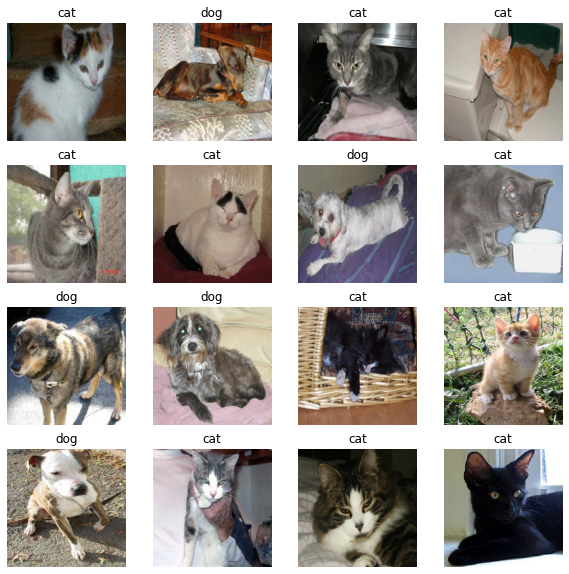

In [15]:
def show_samples_from_iterator(iterator):
    image_batch, label_batch = next(iterator)
    plt.figure(figsize=(10,10))
    for n in range(16):
        ax = plt.subplot(4,4,n+1)
        plt.imshow(image_batch[n, :, :, :])
        plt.title('dog' if label_batch[n] else 'cat')
        plt.axis('off')

show_samples_from_iterator(iter(train_generator))

### Задание 2. Реализуйте глубокую нейронную сеть с как минимум тремя сверточными слоями. Какое качество классификации получено?


In [0]:
layers = [
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(MAX_HEIGHT, MAX_WIDTH, 3)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.8),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid'),
]

In [20]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9)
model = Model(layers=layers, optimizer='adam')

----------------------------------------------------------------------------------------
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 254, 254, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 127, 127, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 125, 125, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 62, 62, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 60, 60, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 30, 30, 128)       0         
_________________________________

----------------------------------------------------------------------------------------
Started at 2020-04-19 23:58:59.020848
----------------------------------------------------------------------------------------
Train on full data
----------------------------------------------------------------------------------------
Epoch 1/15
235/234 [==============================] - 36s 151ms/step - loss: 0.7167 - accuracy: 0.5505 - val_loss: 0.6675 - val_accuracy: 0.6056
Epoch 2/15
235/234 [==============================] - 36s 154ms/step - loss: 0.6293 - accuracy: 0.6451 - val_loss: 0.6477 - val_accuracy: 0.6092
Epoch 3/15
235/234 [==============================] - 36s 154ms/step - loss: 0.5701 - accuracy: 0.7059 - val_loss: 0.4984 - val_accuracy: 0.7710
Epoch 4/15
235/234 [==============================] - 36s 153ms/step - loss: 0.4978 - accuracy: 0.7596 - val_loss: 0.4923 - val_accuracy: 0.7744
Epoch 5/15
235/234 [==============================] - 36s 153ms/step - loss: 0.4686 - accuracy: 

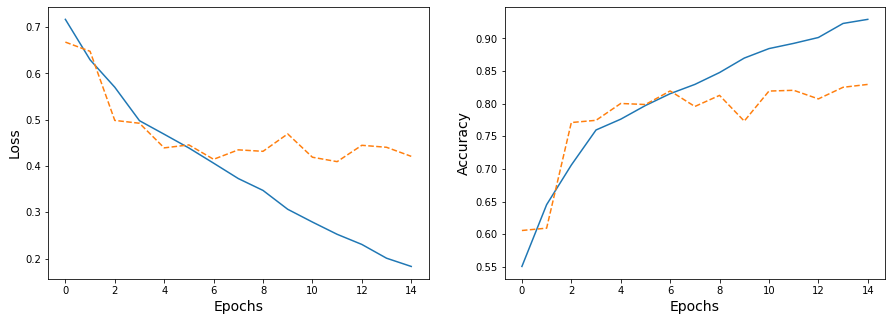

----------------------------------------------------------------------------------------
Spent time: 0:09:13.338240
Average loss error: 0.3933461427688599
Average train error: 0.8083955605824789
Average validation loss error: 0.47168323198954265
Average validation error: 0.777400000890096
----------------------------------------------------------------------------------------
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: /content/drive/My Drive/Colab Notebooks/5/model/assets


In [21]:
steps_per_epoch = len(x_train) / BATCH_SIZE
validation_steps = len(x_validation) / BATCH_SIZE

with tf.device('/device:GPU:0'):
    history = model.train(iter(train_generator), epochs=15, workers=4,
                          steps_per_epoch=steps_per_epoch, validation_steps=validation_steps,
                          validation_data=iter(validation_generator))
    model.save(filedir='/content/drive/My Drive/Colab Notebooks/5/', filename='model')

In [22]:
with tf.device('/device:GPU:0'):
    history = model.test(iter(test_generator), steps=len(test_generator))

79/79 [==============================] - 18s 227ms/step - loss: 0.4437 - accuracy: 0.8192


Качество классификации составило:
- 0.93 на обучающей выборке
- 0.83 на валидационной
- 0.81 на тестовой

### Задание 3. Примените дополнение данных (data augmentation). Как это повлияло на качество классификатора? 


In [0]:
def create_augmentation_generator(x, y, target_size=(MAX_HEIGHT, MAX_WIDTH)):
    dataframe = pd.DataFrame({'filename': x, 'class': y })

    image_generator = tf.keras.preprocessing.image.ImageDataGenerator(
        rescale=1./255,
        rotation_range=90.,
        zoom_range=0.2,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.15,
        horizontal_flip=True,
        brightness_range=(0.2,0.8),
        fill_mode="nearest"
    )

    data_generator = image_generator.flow_from_dataframe(
        dataframe, target_size=target_size, class_mode='binary', batch_size=BATCH_SIZE, shuffle=True
    )
    return data_generator

In [27]:
train_augmentation_generator = create_augmentation_generator(x_train, y_train)

Found 15000 validated image filenames belonging to 2 classes.


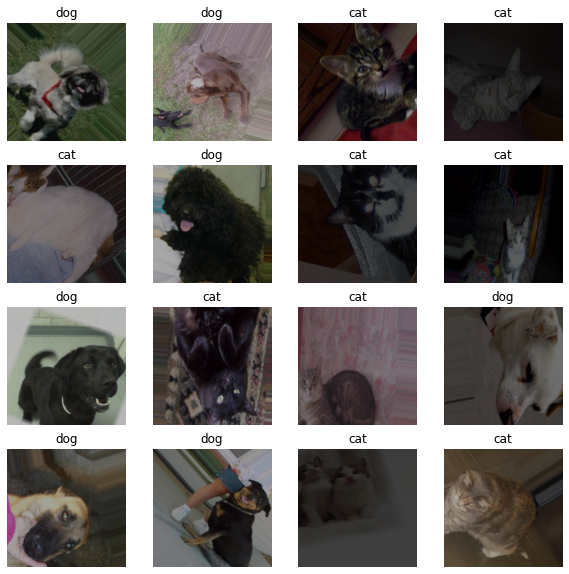

In [28]:
show_samples_from_iterator(iter(train_augmentation_generator))

----------------------------------------------------------------------------------------
Started at 2020-04-20 00:17:46.440374
----------------------------------------------------------------------------------------
Train on full data
----------------------------------------------------------------------------------------
Epoch 1/20
235/234 [==============================] - 148s 628ms/step - loss: 0.6218 - accuracy: 0.6549 - val_loss: 0.5336 - val_accuracy: 0.7282
Epoch 2/20
235/234 [==============================] - 144s 615ms/step - loss: 0.5877 - accuracy: 0.6871 - val_loss: 0.4744 - val_accuracy: 0.7866
Epoch 3/20
235/234 [==============================] - 144s 612ms/step - loss: 0.5672 - accuracy: 0.7045 - val_loss: 0.5006 - val_accuracy: 0.7700
Epoch 4/20
235/234 [==============================] - 143s 607ms/step - loss: 0.5573 - accuracy: 0.7127 - val_loss: 0.4898 - val_accuracy: 0.7692
Epoch 5/20
235/234 [==============================] - 144s 612ms/step - loss: 0.5547 - accur

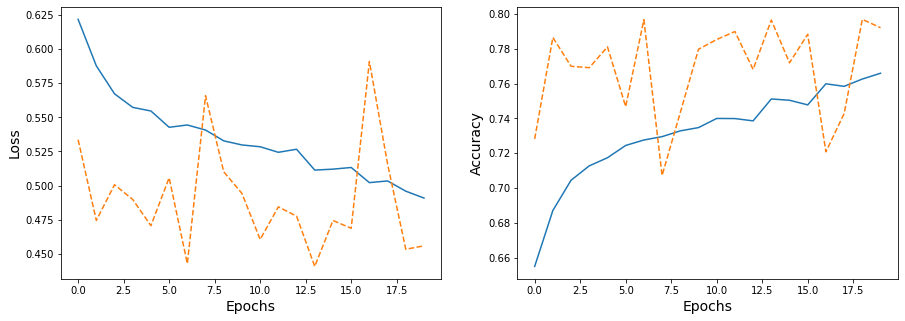

----------------------------------------------------------------------------------------
Spent time: 0:48:45.079758
Average loss error: 0.5343700721859932
Average train error: 0.7320399969816208
Average validation loss error: 0.4904877856373787
Average validation error: 0.7681299984455109
----------------------------------------------------------------------------------------
INFO:tensorflow:Assets written to: /content/drive/My Drive/Colab Notebooks/5/aug_model/assets


In [26]:
validation_steps = len(x_validation) / BATCH_SIZE
steps_per_epoch = len(x_train) / BATCH_SIZE

with tf.device('/device:GPU:0'):
    history = model.train(iter(train_augmentation_generator), epochs=20, workers=4, steps_per_epoch=steps_per_epoch,
                          validation_steps=validation_steps, validation_data=validation_generator)
    model.save(filedir='/content/drive/My Drive/Colab Notebooks/5/', filename='aug_model')

In [27]:
with tf.device('/device:GPU:0'):
    history = model.test(iter(test_generator), steps=len(test_generator))

79/79 [==============================] - 26s 333ms/step - loss: 0.4626 - accuracy: 0.7904


Качество классификатора ухудшилось на 15% на обучающей выборке, однако на валидационной и на тестовой выборках всего на 2%.

### Задание 4. Поэкспериментируйте с готовыми нейронными сетями (например, AlexNet, VGG16, Inception и т.п.), применив передаточное обучение. Как это повлияло на качество классификатора? Какой максимальный результат удалось получить на сайте Kaggle? Почему?


#### VGG16

In [0]:
def VGG16():
    # load pretrained vgg16
    pretrain_model = tf.keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=(MAX_HEIGHT, MAX_WIDTH, 3))
    # Make vgg16 model layers as non trainable
    for layer in pretrain_model.layers:
        layer.trainable = False

    # create custom output layer
    flatten_tensor = tf.keras.layers.Flatten()(pretrain_model.output)
    output_tensor = tf.keras.layers.Dense(1, activation='sigmoid')(flatten_tensor)

    # gather layers and create model
    pretrain_model = tf.keras.Model(inputs=pretrain_model.input, outputs=output_tensor)
    pretrain_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.1), loss='binary_crossentropy', metrics=['accuracy'])
    return pretrain_model

In [22]:
vgg16_model = Model(model=VGG16())

----------------------------------------------------------------------------------------
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
____________________________________

----------------------------------------------------------------------------------------
Started at 2020-04-20 01:25:34.077053
----------------------------------------------------------------------------------------
Train on full data
----------------------------------------------------------------------------------------
Epoch 1/10
235/234 [==============================] - 65s 278ms/step - loss: 8.6016 - accuracy: 0.8692 - val_loss: 3.8291 - val_accuracy: 0.9096
Epoch 2/10
235/234 [==============================] - 65s 275ms/step - loss: 2.7008 - accuracy: 0.9335 - val_loss: 5.7514 - val_accuracy: 0.8908
Epoch 3/10
235/234 [==============================] - 65s 276ms/step - loss: 2.0313 - accuracy: 0.9492 - val_loss: 4.5395 - val_accuracy: 0.9156
Epoch 4/10
235/234 [==============================] - 65s 276ms/step - loss: 2.0538 - accuracy: 0.9559 - val_loss: 5.5510 - val_accuracy: 0.9202
Epoch 5/10
235/234 [==============================] - 65s 276ms/step - loss: 1.5068 - accuracy: 

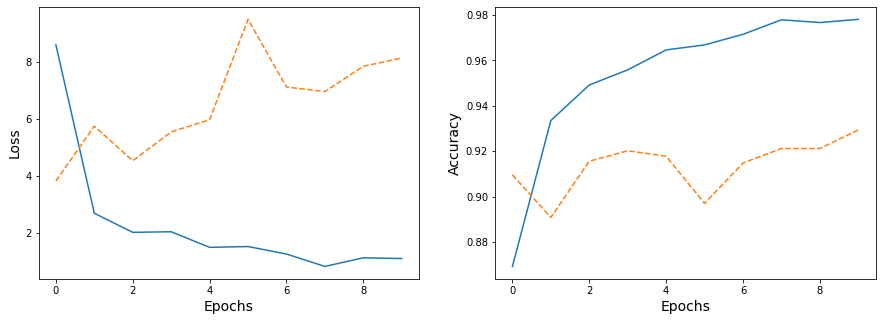

----------------------------------------------------------------------------------------
Spent time: 0:10:51.919824
Average loss error: 2.2796885907649993
Average train error: 0.9543666660785675
Average validation loss error: 6.520841979980469
Average validation error: 0.9137600004673004
----------------------------------------------------------------------------------------
INFO:tensorflow:Assets written to: /content/drive/My Drive/Colab Notebooks/5/vgg16_based_model/assets


In [23]:
validation_steps = len(x_validation) / BATCH_SIZE
steps_per_epoch = len(x_train) / BATCH_SIZE

with tf.device('/device:GPU:0'):
    history = vgg16_model.train(iter(train_generator), epochs=10, workers=4, steps_per_epoch=steps_per_epoch,
                                validation_steps=validation_steps, validation_data=validation_generator)
    vgg16_model.save(filedir='/content/drive/My Drive/Colab Notebooks/5/', filename='vgg16_based_model')

In [24]:
with tf.device('/device:GPU:0'):
    history = vgg16_model.test(iter(test_generator), steps=len(test_generator))

79/79 [==============================] - 18s 230ms/step - loss: 9.2620 - accuracy: 0.9184


Качество классификатора значительно улучшилось. Таким образом, лучше всех на тестовой выборке показала себя модель VGG16.

#### Создание предсказаний Kaggle

In [0]:
with zipfile.ZipFile(f'{DRIVE_DIR}test1.zip', 'r') as zip_ref:
    zip_ref.extractall('./datasets/test/')

test1_data_dir = pathlib.Path('./datasets/test/')

len(list(test1_data_dir.glob('*')))

In [0]:
def create_image_generator(data_dir, target_size=(MAX_HEIGHT, MAX_WIDTH), batch_size=BATCH_SIZE):
    image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
    data_generator = image_generator.flow_from_directory(
        directory=str(data_dir), target_size=target_size, class_mode=None, batch_size=batch_size
    )
    return data_generator

In [0]:
test1_data_generator = create_image_generator(test1_data_dir)

In [0]:
def predict_by_model(model, generator, filename):
    results = model.predict(generator, verbose=1, workers=4, steps=len(generator))
    int_results = np.rint(results).astype(int)
    df = pd.DataFrame(data={'id': list(range(1, int_results.shape[0] + 1)), 'label': int_results[:, 0]})
    df.to_csv(f'{filename}.csv', index=False)  

In [0]:
predict_by_model(model, test1_data_generator, '/content/drive/My Drive/Colab Notebooks/5/model_submission')

In [0]:
predict_by_model(vgg16_model, test1_data_generator, '/content/drive/My Drive/Colab Notebooks/5/vgg16_model_submission')